In [0]:
# Installing packages
%%time 
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

In [0]:
# functions
api_key = 'YOUR_API_KEY' # Acquire from developer.here.com

def geocoding_HERE(data, adress, city, api_key):
    URL = "https://geocode.search.hereapi.com/v1/geocode"

    data['latitude'] = np.nan
    data['longitude'] = np.nan
    errores = 0

    for x in range(len(data)):
       
        location = data[adress][x] + "Madrid, Spain"
        PARAMS = {'apikey': api_key, 'q': location}
         # sending get request and saving the response as response object
        r = requests.get(url=URL, params=PARAMS)
        place = r.json()

        try:
            place = [lugar for lugar in place["items"] if lugar["address"]["county"] == city]
            data.loc[x, 'latitude']  = place[0]['position']['lat']
            data.loc[x, 'longitude'] = place[0]['position']['lng']
        except:
            errores = errores + 1

    print(str(errores) + " no encontrados")

    return(data)


def add_popup(data, i):
  
  pop = """
  {}
    <table class="egt">
      <tr>
    <td align="left">Número total de multas:</td>
    <td align="right">{}</td>
    <td align="left"> </td>
      </tr>
      <tr>   
    <td align="left">Multas leves:</td>
    <td align="right">{} </td>
    <td align="right"> ( {:.2%})</td>
      </tr>
      <tr>   
    <td align="left">Multas graves:</td>
    <td align="right">{} </td>
    <td align="right"> ( {:.2%})</td>
      </tr>
      <tr>   
    <td align="left">Multas muy graves:</td>
    <td align="right">{} </td>
    <td align="right"> ( {:.2%})</td>
      </tr>
        </table>
        """.format(data["NOMBRE"][i],    data["TOTAL"][i],
                   data["LEVE"][i],      data["percent LEVE"][i],
                   data["GRAVE"][i],     data["percent GRAVE"][i],
                   data["MUY GRAVE"][i], data["percent MUY GRAVE"][i])
  return(pop)


In [2]:
# Import packages
import pandas as pd
import seaborn as sns
import geopandas as gpd
import folium
import numpy as np
from shapely.geometry import Point
import branca.colormap as cm
import matplotlib.pyplot as plt
import pyproj
import requests
from folium import FeatureGroup
import rtree

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data_geo = pd.read_csv("data_complete.csv", sep = ";", encoding='latin1', skipinitialspace=True)
data_geo = data_geo.loc[data_geo["latitude"].notna(),:]
data0 = pd.read_csv("202001_detalle.csv", sep = ";", encoding='latin1', skipinitialspace=True)
data = pd.merge(data0, data_geo, on = "LUGAR", how = "left")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132073 entries, 0 to 132072
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CALIFICACION  132073 non-null  object 
 1   LUGAR         132073 non-null  object 
 2   MES_x         132072 non-null  float64
 3   ANIO          132072 non-null  float64
 4   HORA          132072 non-null  float64
 5   IMP_BOL       132072 non-null  float64
 6   DESCUENTO     132072 non-null  object 
 7   PUNTOS        132072 non-null  float64
 8   DENUNCIANTE   132072 non-null  object 
 9   HECHO-BOL     132072 non-null  object 
 10  VEL_LIMITE    3 non-null       float64
 11  VEL_CIRCULA   3 non-null       float64
 12  COORDENADA_X  66225 non-null   float64
 13  COORDENADA_Y  66225 non-null   float64
 14  MES_y         123806 non-null  float64
 15  latitude      123806 non-null  float64
 16  longitude     123806 non-null  float64
dtypes: float64(12), object(5)
memory usage: 18.1+ MB

In [0]:
# Clean data
data_no_coords["CALIFICACION"] = data_no_coords["CALIFICACION"].str.rstrip()
data_no_coords["LUGAR"]        = data_no_coords["LUGAR"].str.rstrip()
data_no_coords["HECHO-BOL"]    = data_no_coords["HECHO-BOL"].str.rstrip()
data_no_coords["HORA"]         = data_no_coords["HORA"].astype(float).astype(int)

# Geolocalize all distinct locations
locations   = data_no_coords.groupby("LUGAR").size().reset_index(name = 'counts')
coordenades = geocoding_HERE(locations, "LUGAR", "Madrid", api_key)

# Add the coords to data
data = pd.merge(coordenades, data_no_coords, on = "LUGAR")
geom = data.apply(lambda x : Point([x["longitude"], x["latitude"]]), axis = 1)
data = gpd.GeoDataFrame(data, geometry = geom) 
data.crs = "EPSG:4326"


In [0]:
# Combine info of .shp of distrits and neighborhoods
districts = gpd.GeoDataFrame.from_file('DISTRITOS.shp')
districts = distritos.to_crs("EPSG:4326")

neighborhoods = gpd.GeoDataFrame.from_file('BARRIOS.shp')
neighborhoods = barrios.to_crs("EPSG:4326")

# Combine .shp with data
data_dist = gpd.sjoin(data, districts, 
                      how = "right", 
                      op  = 'intersects')

data_neighborhoods = gpd.sjoin(data, neighborhoods, 
                               how = "right", 
                               op  = 'intersects')

In [0]:
sns.set(style="darkgrid")
# The most common causes
grade = "MUY GRAVE"
(data_dist.loc[data_dist["CALIFICACION"]== grade,:]
    .groupby("HECHO-BOL").size().reset_index(name = 'counts')
    .sort_values(by = ["counts"],ascending = False).head(10)
)


In [0]:

sns.catplot(y = "CALIFICACION",kind = "count", data = data_dist)


In [0]:
sns.catplot(y = "DENUNCIANTE",kind = "count", data = data_dist)


In [0]:
# For neighborhoods
data_join1 = data_neighborhoods.groupby(["CALIFICACION", 
                                         "CODBAR"]).size().unstack("CALIFICACION").reset_index().fillna(0)

data_join1["TOTAL"] = data_join1["GRAVE"] + data_join1["MUY GRAVE"] +data_join1["LEVE"]
data_join2 = pd.merge(barrios,data_join1, on = "CODBAR")

In [0]:
# For districts
data_join1=data_dist.groupby(["CALIFICACION",
                              "CODDISTRIT"]).size().unstack("CALIFICACION").reset_index().fillna(0)

data_join1["TOTAL"] = data_join1["GRAVE"] + data_join1["MUY GRAVE"] +data_join1["LEVE"]
data_join2 = pd.merge(distritos, data_join1, on = "CODDISTRIT")


In [129]:
# For neighborhoods
data_join2["percent GRAVE"] = data_join2["GRAVE"]/data_join2["TOTAL"]
data_join2["percent MUY GRAVE"] = data_join2["MUY GRAVE"]/data_join2["TOTAL"]
data_join2["percent LEVE"] = data_join2["LEVE"]/data_join2["TOTAL"]



m = folium.Map(location=[40.07654 ,	-3.49837], zoom_start = 9.5)


tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain', "cartodbdark_matter"]
for tile in tiles:
    folium.TileLayer(tile).add_to(m)


choropleth = folium.Choropleth(
    geo_data        = neighborhoods,
    data            = data_join2,
    columns         = ['CODBAR', 'TOTAL'],
    key_on          = 'feature.properties.CODBAR', 
    fill_opacity    = 0.7,
    fill_color      = 'OrRd',
    name            = "Total",
    line_opacity    = 0.2,
    legend_name     = 'Total de multas',
    threshold_scale = [0,  1000,  5000, 10000, 15000, 23100],
    smooth_factor   = 0).add_to(m)

choropleth = folium.Choropleth(
    geo_data        = neighborhoods,
    data            = data_join2,
    columns         = ['CODBAR', 'LEVE'],
    key_on          = 'feature.properties.CODBAR', 
    fill_opacity    = 0.7,
    fill_color      = 'OrRd',
    name            = "Total",
    line_opacity    = 0.2,
    legend_name     = 'Total de multas leves',
    threshold_scale = [0,  1000, 6000, 10000,15000, 22860],
    smooth_factor   = 0).add_to(m)

choropleth = folium.Choropleth(
    geo_data        = neighborhoods,
    data            = data_join2,
    columns         = ['CODBAR', 'GRAVE'],
    key_on          = 'feature.properties.CODBAR', 
    fill_opacity    = 0.7,
    fill_color      = 'OrRd',
    name            = "Total",
    line_opacity    = 0.2,
    legend_name     = 'Total de multas graves',
    threshold_scale = [0,  300, 2800, 5000,7000, 9190],
    smooth_factor   = 0).add_to(m)

choropleth = folium.Choropleth(
    geo_data        = neighborhoods,
    data            = data_join2,
    columns         = ['CODBAR', 'MUY GRAVE'],
    key_on          = 'feature.properties.CODBAR', 
    fill_opacity    = 0.7,
    fill_color      = 'OrRd',
    name            = "Total",
    line_opacity    = 0.2,
    legend_name     = 'Total de multas graves',
    smooth_factor   = 0).add_to(m)



feature_group = FeatureGroup(name = "Popup")

for i in range(len(data_join2)):

        gs = folium.GeoJson(data_join2.iloc[i:i+1],
                            style_function=lambda feature: {'fillOpacity' : 0})
        label = add_popup(data_join2, i)
        iframe = folium.IFrame(html=label, width=350, height=250)
        folium.Popup(iframe).add_to(gs)
        feature_group.add_child(gs)

        
        feature_group.add_to(m)
folium.LayerControl(collapsed=True).add_to(m)

m


In [118]:
# For districts

data_join2["percent GRAVE"] = data_join2["GRAVE"]/data_join2["TOTAL"]
data_join2["percent MUY GRAVE"] = data_join2["MUY GRAVE"]/data_join2["TOTAL"]
data_join2["percent LEVE"] = data_join2["LEVE"]/data_join2["TOTAL"]

m = folium.Map(location=[40.07654 ,	-3.49837], zoom_start = 9.5)


tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain', "cartodbdark_matter"]
for tile in tiles:
    folium.TileLayer(tile).add_to(m)


choropleth = folium.Choropleth(
    geo_data        = districts,
    data            = data_join2,
    columns         = ['CODDISTRIT', 'TOTAL'],
    key_on          = 'feature.properties.CODDISTRIT', 
    fill_opacity    = 0.7,
    fill_color      = 'OrRd',
    name            = "Total",
    line_opacity    = 0.2,
    legend_name     = 'Total de multas',
    threshold_scale = [347,  5000, 15000, 30000, 50000, 63100],
    smooth_factor   = 0).add_to(m)

choropleth = folium.Choropleth(
    geo_data        = districts,
    data            = data_join2,
    columns         = ['CODDISTRIT', 'LEVE'],
    key_on          = 'feature.properties.CODDISTRIT', 
    fill_opacity    = 0.7,
    fill_color      = 'OrRd',
    name            = "Leves",
    line_opacity    = 0.2,
    legend_name     = 'Total de multas leves',
    threshold_scale=[121,  5000, 15000, 30000, 50000, 62000],
    smooth_factor   = 0).add_to(m)

choropleth = folium.Choropleth(
    geo_data        = districts,
    data            = data_join2,
    columns         = ['CODDISTRIT', 'GRAVE'],
    key_on          = 'feature.properties.CODDISTRIT', 
    fill_opacity    = 0.7,
    fill_color      = 'OrRd',
    name            = "Graves",
    line_opacity    = 0.2,
    legend_name     = 'Total de multas graves',
    smooth_factor   = 0).add_to(m)

choropleth = folium.Choropleth(
    geo_data        = districts,
    data            = data_join2,
    columns         = ['CODDISTRIT', 'MUY GRAVE'],
    key_on          = 'feature.properties.CODDISTRIT', 
    fill_opacity    = 0.7,
    fill_color      = 'OrRd',
    name            = "Muy graves",
    line_opacity    = 0.2,
    legend_name     = 'Total de multas muy graves',
    smooth_factor   = 0).add_to(m)


feature_group = FeatureGroup(name = "Popup")

for i in range(len(data_join2)):

        gs = folium.GeoJson(data_join2.iloc[i:i+1],
                            style_function = lambda feature: {'fillOpacity' : 0})
        label  = add_popup(data_join2, i)
        iframe = folium.IFrame(html = label, width = 350, height = 250)
        folium.Popup(iframe).add_to(gs)
        feature_group.add_child(gs)

        
        feature_group.add_to(m)
folium.LayerControl(collapsed = True).add_to(m)

m

In [0]:
# For districts


m = folium.Map(location=[40.07654 ,	-3.49837], zoom_start = 9.5)


tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain', "cartodbdark_matter"]
for tile in tiles:
    folium.TileLayer(tile).add_to(m)



choropleth = folium.Choropleth(
    geo_data        = districts,
    data            = data_join2,
    columns         = ['CODDISTRIT', 'percent LEVE'],
    key_on          = 'feature.properties.CODDISTRIT', 
    fill_opacity    = 0.7,
    fill_color      = 'OrRd',
    name            = "Leve",
    line_opacity    = 0.2,
    legend_name     = 'Porcentaje de multas leves',
    smooth_factor   = 0).add_to(m)

choropleth = folium.Choropleth(
    geo_data        = districts,
    data            = data_join2,
    columns         = ['CODDISTRIT', 'percent GRAVE'],
    key_on          = 'feature.properties.CODDISTRIT', 
    fill_opacity    = 0.7,
    fill_color      = 'OrRd',
    name            = "Grave",
    line_opacity    = 0.2,
    legend_name     = 'Porcentaje de multas graves',
    smooth_factor   = 0).add_to(m)

choropleth = folium.Choropleth(
    geo_data        = districts,
    data            = data_join2,
    columns         = ['CODDISTRIT', 'percent MUY GRAVE'],
    key_on          = 'feature.properties.CODDISTRIT', 
    fill_opacity    = 0.7,
    fill_color      = 'OrRd',
    name            = "Muy graves",
    line_opacity    = 0.2,
    legend_name     = 'Porcentaje de multas muy graves',
    smooth_factor   = 0).add_to(m)

feature_group = FeatureGroup(name = "Popup")

for i in range(len(data_join2)):

        gs = folium.GeoJson(data_join2.iloc[i:i+1],
                            style_function = lambda feature: {'fillOpacity' : 0})
        label  = add_popup(data_join2, i)
        iframe = folium.IFrame(html = label, width = 350, height = 250)
        folium.Popup(iframe).add_to(gs)
        feature_group.add_child(gs)

        
        feature_group.add_to(m)
folium.LayerControl(collapsed = True).add_to(m)

m

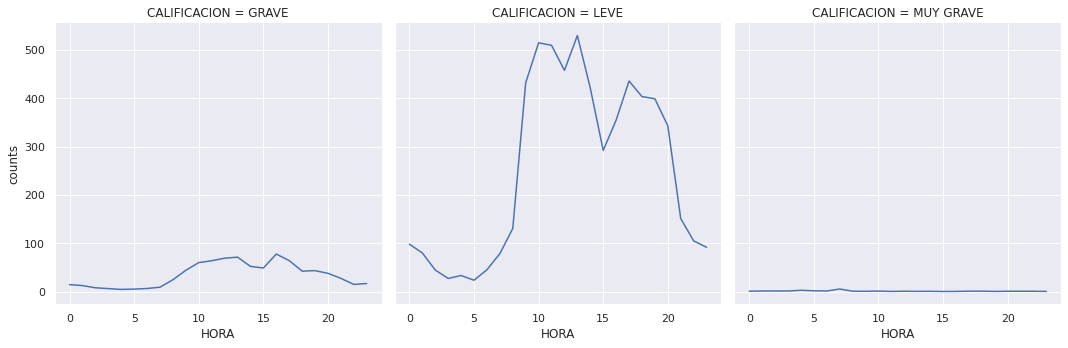

In [134]:

data_group = pd.DataFrame(data_dist.groupby(["HORA", "CALIFICACION", "NOMBRE"]).size().reset_index(name = 'counts'))
fig = sns.relplot(x = "HORA", y = "counts",ci = None,col = "CALIFICACION", kind = "line",data = data_group)


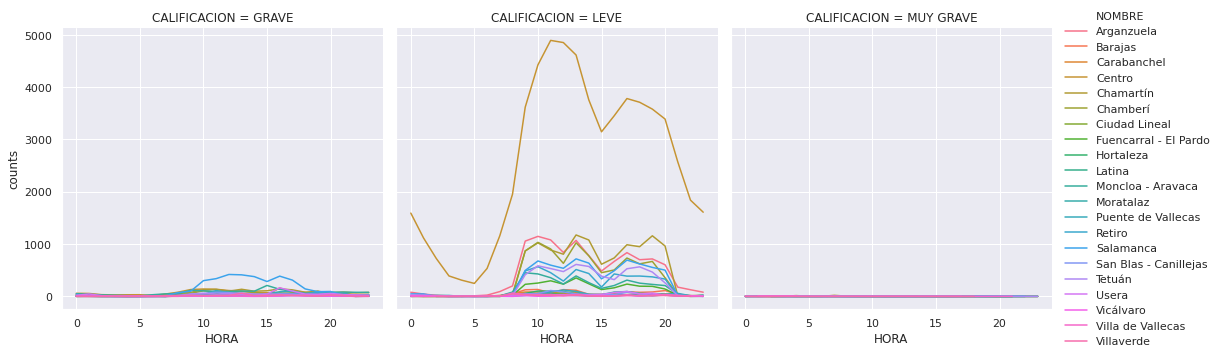

In [133]:
fig = sns.relplot(x = "HORA", y = "counts",ci = None,col = "CALIFICACION",hue = "NOMBRE", kind = "line",data = data_group)
